In [2]:
from qiskit import QuantumCircuit
from qiskit import IBMQ, Aer, transpile, assemble
from qiskit.visualization import plot_histogram

In [3]:
# Bell State

def create_bell_pair(qc, a, b):
    '''
    create a bell pair with circuit qc, control bit a and target bit b
    '''
    
    qc.h(a) # Hadamard to first bit
    qc.cx(a,b) # CNOT on both 
    

After preparation, the qubits are being sent to Alice and Bob. Next, Alice has to encode her classical bit sequence by manipulating her qubit. We will do this yet another function.

In [4]:
def encode_message(qc, qubit, msg):
    '''
    qc... quantum circuit
    qubit... Alice's qubit
    msg... 00,01,10 or 11
    '''
    
    if msg == "00":
        pass # identity

    elif msg == "10":
        qc.x(qubit)
        
    elif msg == "01":
        qc.z(qubit)
        
    elif msg == "11":
        qc.z(qubit)
        qc.x(qubit)
    else:
        print("Invalid sequence. Sending '00'. ")

After encoding, Alice sends her qubit to Bob. Now Bob can start decoding the message.

In [5]:
def decode_message(qc, a, b):
    '''
    qc... quantum circuit
    a... qubit 0
    b... qubit 1
    '''
    
    qc.cx(a,b)
    qc.h(a)

Now we can assemble the full quantum circuit using the functions that we defined above.

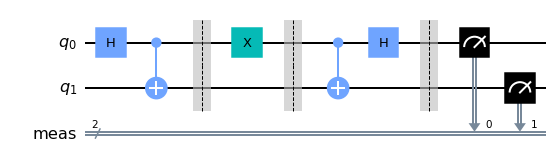

In [7]:
qc = QuantumCircuit(2) # 2-qubit quantum circuit

# step a) preparation
create_bell_pair(qc, 0, 1)
qc.barrier() # visual segmentation of the circuit, no implication

# step b) sending one qubit to Alice and the other to Bob

# step c) (encoding, Alice)
# choose message
message = "10"
encode_message(qc, 0, message)
qc.barrier() # visual segmentation of the circuit, no implication

# step d) Alice sends her qubit to Bob

# step e) decoding(Bob)
decode_message(qc, 0, 1)
qc.measure_all()

# draw circuit
qc.draw('mpl')

Now let's run this circuit using a simulator

In [ ]:
aer_sim = Aer.get_backend("aer_simulator")
qobj = assemble(qc)
result = aer_sim.run(qobj).result()
count = result.get_counts(qc)
print(count)
plot_histogram(count)

Now we will use the IBM Quantum Experience API to run this circuit on an actual quantum computer.

In [12]:
from qiskit import IBMQ
from qiskit.providers.ibmq import least_busy
shots = 1024

TOKEN = '89c70d1108a6478f58c22b4dba84a9df24ec96c37b14e28707c93099b16de3ddea0c97e5265b03fcbbef4505ff3f72fc025c861bf0b4aea23deb03eefdbf703f'
IBMQ.save_account(TOKEN) # prepare account for using API
 
# Load local account information
IBMQ.load_account()
# Get the least busy backend
provider = IBMQ.get_provider(hub='ibm-q')
backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= 2 
                                       and not x.configuration().simulator 
                                       and x.status().operational==True))
print("least busy backend: ", backend)
# Run our circuit
t_qc = transpile(qc, backend, optimization_level=3)
job = backend.run(t_qc)

least busy backend:  ibmq_bogota


In [13]:
# Monitoring our job
from qiskit.tools.monitor import job_monitor
job_monitor(job)

Job Status: job has successfully run


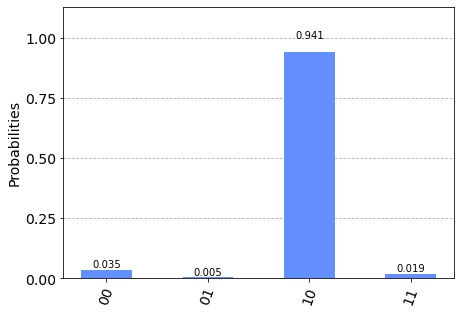

In [14]:
# Plotting our result
result = job.result()
plot_histogram(result.get_counts(qc))